In [1]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import models, layers
import tensorflow as tf
import ast
import librosa
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization,Activation
from tensorflow.keras.optimizers import Adam


In [2]:
train_csv = pd.read_csv('training_data.csv')
test_csv = pd.read_csv('test_data.csv')

labels = train_csv['instrument'].unique()
#spelling error in the test_data we need to account for
label_encoder = {'Sound_Guiatr' : 0}
for index, label in enumerate(labels):
    label_encoder[label] = index

print(labels)
train_csv['instrument'].value_counts()

['Sound_Guitar' 'Sound_Drum' 'Sound_Violin' 'Sound_Piano']


instrument
Sound_Piano     33310
Sound_Guitar    19158
Sound_Drum      19022
Sound_Violin    19022
Name: count, dtype: int64

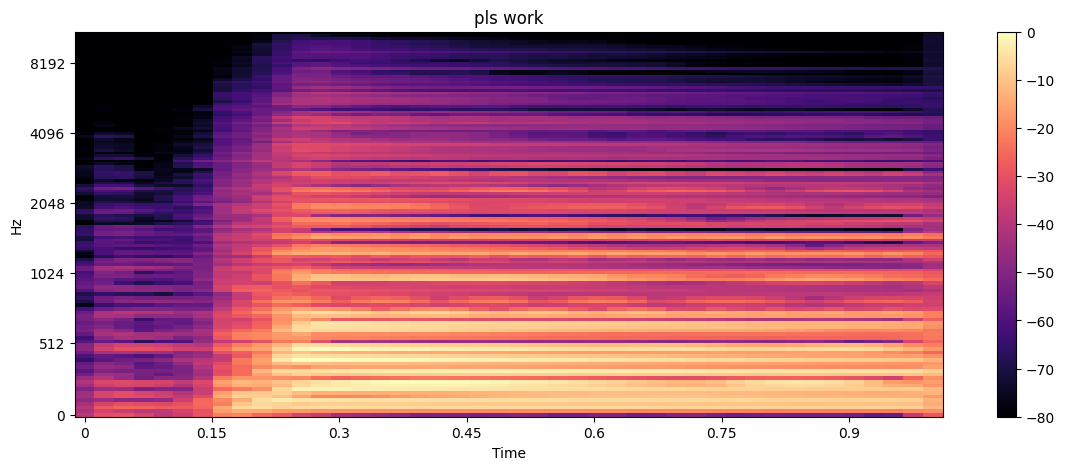

In [3]:
#testing our data has survived
train_csv.head()
flat_mel_spec = np.loadtxt(f'./train_mel_spec/00.txt')
mel_spec = flat_mel_spec.reshape(128,44)
plt.figure(figsize=(14,5))

librosa.display.specshow(mel_spec, sr=22050, x_axis='time', y_axis='mel')
plt.title('pls work')
plt.colorbar()

In [4]:
#preparing training data

guitar_df = train_csv[train_csv['instrument'] == 'Sound_Guitar']
piano_df = train_csv[train_csv['instrument'] == 'Sound_Drum']
drum_df = train_csv[train_csv['instrument'] == 'Sound_Violin']
violin_df = train_csv[train_csv['instrument'] == 'Sound_Piano']

#750 examples from each for intail training
data_combind_train_validation = guitar_df['mel spec ref'].tolist()[:750]
labels_combind_train_validation = guitar_df['instrument'].tolist()[:750]

data_combind_train_validation.extend(piano_df['mel spec ref'].tolist()[:750])
labels_combind_train_validation.extend(piano_df['instrument'].tolist()[:750])

data_combind_train_validation.extend(drum_df['mel spec ref'].tolist()[:750])
labels_combind_train_validation.extend(drum_df['instrument'].tolist()[:750])

data_combind_train_validation.extend(violin_df['mel spec ref'].tolist()[:750])
labels_combind_train_validation.extend(violin_df['instrument'].tolist()[:750])


#mel spec data and reshape it
for index, data in enumerate(data_combind_train_validation): 
    data_combind_train_validation[index] = np.loadtxt(f'./train_mel_spec/{data}').reshape((128, 44))
 
#change labels to 0-4   
for index, data in enumerate(labels_combind_train_validation):
    labels_combind_train_validation[index] = label_encoder[data]
    

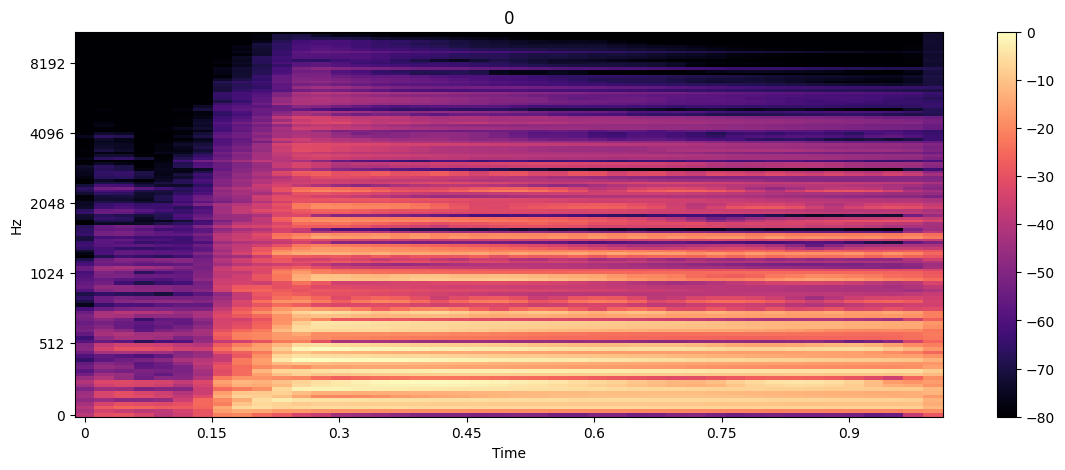

In [5]:
#testing the conversion has worked
plt.figure(figsize=(14,5))
librosa.display.specshow(data_combind_train_validation[0], sr=22050, x_axis='time', y_axis='mel')
plt.title(labels_combind_train_validation[0])
plt.colorbar()

In [6]:
test_csv['instrument'].value_counts()

instrument
Sound_Guiatr    1536
Sound_Piano     1076
Sound_Drum       843
Sound_Violin     276
Name: count, dtype: int64

In [7]:
#spelling mistake in test data - should be guitar not guiatr
guitar_df = test_csv[test_csv['instrument'] == 'Sound_Guiatr']
piano_df = test_csv[test_csv['instrument'] == 'Sound_Drum']
drum_df = test_csv[test_csv['instrument'] == 'Sound_Violin']
violin_df = test_csv[test_csv['instrument'] == 'Sound_Piano']

data_test = guitar_df['mel spec ref'].tolist()
labels_test = guitar_df['instrument'].tolist()

data_test.extend(piano_df['mel spec ref'].tolist())
labels_test.extend(piano_df['instrument'].tolist())

data_test.extend(drum_df['mel spec ref'].tolist())
labels_test.extend(drum_df['instrument'].tolist())

data_test.extend(violin_df['mel spec ref'].tolist())
labels_test.extend(violin_df['instrument'].tolist())

#mel spec data and reshape it
for index, data in enumerate(data_test): 
    data_test[index] = np.loadtxt(f'./test_mel_spec/{data}').reshape((128, 44))
 
# change labels to 0-4   
for index, data in enumerate(labels_test):
    labels_test[index] = label_encoder[data]
    

In [8]:
input_shape = (128, 44, 1) 

# Define input layer
input_layer = Input(shape=input_shape)

# Define convolutional layers
conv_layer_1 = Conv2D(32, (3, 3), padding='same')(input_layer)
conv_layer_1 = BatchNormalization()(conv_layer_1)
conv_layer_1 = Activation('relu')(conv_layer_1)
max_pool_1 = MaxPooling2D((2, 2))(conv_layer_1)
dropout_1 = Dropout(0.25)(max_pool_1)

conv_layer_2 = Conv2D(64, (3, 3), padding='same')(dropout_1)
conv_layer_2 = BatchNormalization()(conv_layer_2)
conv_layer_2 = Activation('relu')(conv_layer_2)
max_pool_2 = MaxPooling2D((2, 2))(conv_layer_2)
dropout_2 = Dropout(0.25)(max_pool_2)

conv_layer_3 = Conv2D(128, (3, 3), padding='same')(dropout_2)
conv_layer_3 = BatchNormalization()(conv_layer_3)
conv_layer_3 = Activation('relu')(conv_layer_3)
max_pool_3 = MaxPooling2D((2, 2))(conv_layer_3)
dropout_3 = Dropout(0.25)(max_pool_3)

flatten_layer = Flatten()(dropout_3)

# Dense layers
dense_layer_1 = Dense(256)(flatten_layer)
dense_layer_1 = BatchNormalization()(dense_layer_1)
dense_layer_1 = Activation('relu')(dense_layer_1)
dropout_4 = Dropout(0.5)(dense_layer_1)

dense_layer_2 = Dense(128)(dropout_4)
dense_layer_2 = BatchNormalization()(dense_layer_2)
dense_layer_2 = Activation('relu')(dense_layer_2)
dropout_5 = Dropout(0.5)(dense_layer_2)

# Output layers
output_layer_1 = Dense(4, activation='softmax', name='output_1')(dropout_5)
output_layer_2 = Dense(5, activation='softmax', name='output_2')(dropout_5)

model = tf.keras.Model(inputs=[input_layer], outputs=[output_layer_1, output_layer_2])

model.summary() 


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 44,   │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 44,   │        320 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128, 44,   │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 128, 44,   │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 22,    │          0 │ activation[0][0]  │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64, 22,    │          0 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 64, 22,    │     18,496 │ dropout[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 22,    │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 64, 22,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 11,    │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 32, 11,    │          0 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 32, 11,    │     73,856 │ dropout_1[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 11,    │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 32, 11,    │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 5,     │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 16, 5,     │          0 │ max_pooling2d_2[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 10240)     │          0 │ dropout_2[0][0] 

 Total params: 2,750,857 (10.49 MB)

 Trainable params: 2,749,641 (10.49 MB)

 Non-trainable params: 1,216 (4.75 KB)

In [9]:
#history reporter
def report(history,y_pred,y_true):
    plt.plot(history.epoch, history.history["accuracy"],history.history['val_accuracy'])
    plt.xlabel('epochs')
    plt.ylabel('accuracy')
    plt.suptitle('Training (blue) and validation (orange) History')
    plt.show()
    
    predicted= np.argmax(y_pred,axis=1)
    actual = np.argmax(y_true,axis=1)
    print(f'Test Accuracy {(predicted==actual).sum() *100/len(actual)}%')
    cm=ConfusionMatrixDisplay.from_predictions(actual, predicted)#,display_labels=train_csv['instrument'].unique()) 

In [10]:


x_train,x_val,y_train,y_val= train_test_split(data_combind_train_validation, labels_combind_train_validation,
                                                test_size=0.125,
                                                shuffle=True,
                                                stratify=labels_combind_train_validation)


In [ ]:
model.compile(optimizer='adam',
              loss=[tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                    tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)],
              metrics=['accuracy', 'accuracy'])

history = model.fit(np.array(x_train), [np.array(y_train), np.array(y_train)],  # Providing y_train twice as there are two outputs
                    epochs=10, validation_data=(np.array(x_val), [np.array(y_val), np.array(y_val)]))  # Providing y_val twice as there are two outputs


Epoch 1/10


/Users/kacperdrupisz/University/aai-song-inspector/venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/nn.py:602: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


83/83 ━━━━━━━━━━━━━━━━━━━━ 11s 118ms/step - loss: 2.9319 - output_1_accuracy: 0.4437 - output_2_accuracy: 0.4002 - val_loss: 7.8365 - val_output_1_accuracy: 0.3333 - val_output_2_accuracy: 0.2747
Epoch 2/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 10s 119ms/step - loss: 1.5478 - output_1_accuracy: 0.6471 - output_2_accuracy: 0.6328 - val_loss: 1.4579 - val_output_1_accuracy: 0.6480 - val_output_2_accuracy: 0.6240
Epoch 3/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 10s 123ms/step - loss: 1.2595 - output_1_accuracy: 0.6721 - output_2_accuracy: 0.6918 - val_loss: 1.1727 - val_output_1_accuracy: 0.6720 - val_output_2_accuracy: 0.6667
Epoch 4/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 10s 116ms/step - loss: 1.0712 - output_1_accuracy: 0.7088 - output_2_accuracy: 0.6934 - val_loss: 0.9568 - val_output_1_accuracy: 0.7120 - val_output_2_accuracy: 0.7173
Epoch 5/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 11s 132ms/step - loss: 0.9818 - output_1_accuracy: 0.7191 - output_2_accuracy: 0.7279 - val_loss: 0.9779 - val_output_1_accuracy: 0.6693 - val_ou

In [ ]:
y_pred = model.predict(np.array(data_test))
report(history, y_pred, labels_test)